In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import glob
import scipy.stats
import os
import cartopy.crs as ccrs
from mpl_toolkits.basemap import Basemap
import scipy.stats

In [2]:

def pca_spearman_corr(nc_file, z_500, pr,lat_start,lat_end,lon_start,lon_end):
    # open and subset to your domain (lat, lon, time)
    ds1 = xr.open_dataset(nc_file)
    ds1 = ds1.sel(
        lat=slice(lat_start, lat_end),
        lon=slice(lon_start,lon_end),
    )

    # get spatial coordinate vectors and sizes
    lat_zg = ds1['lat']
    lon_zg = ds1['lon']
    nrow_zg = lat_zg.size
    ncol_zg = lon_zg.size

    # coerce inputs
    a = z_500       # expected shape (time, space_flat)
    b1 = pr         # expected shape (time,)

    # PCA denoise (cap components safely)
    a_zg = PCA(n_components=9)
    a_reduced = a_zg.fit_transform(a)
    
    zg_f = a_zg.inverse_transform(a_reduced)

    # mean over time of the denoised flattened field
    denoised_z500 = zg_f.mean(axis=1)

    # reshape back to (lat, lon, time) using Fortran order as you did
    rp = np.reshape(zg_f.T, (nrow_zg, ncol_zg, 36), order='F')
    import scipy.stats
    # Spearman correlation at each grid cell
    cor        = np.full((nrow_zg, ncol_zg), np.nan, dtype=float)
    cor_p      = np.full((nrow_zg, ncol_zg), np.nan, dtype=float)

    for i in range(nrow_zg):
        for j in range(ncol_zg):
            r, p = scipy.stats.spearmanr(rp[i, j, :], b1, nan_policy='omit')
            cor[i, j]   = r
            cor_p[i, j] = p

    # significance mask
    sig_mask = (cor_p < 0.1) & np.isfinite(cor)

    # lat/lon lists for significant points
    y, x = np.where(sig_mask)
    x_list1 = x.tolist()
    y_list1 = y.tolist()
    lat_ls = lat_zg.values.tolist()
    lon_ls = lon_zg.values.tolist()
    lat_list1 = [lat_ls[idx] for idx in y_list1]
    lon_list1 = [lon_ls[idx] for idx in x_list1]

    cor_array = cor

    ds1.close()
    return {
        "cor_array": cor_array,
        "denoised_z500": denoised_z500,
        "lat_list1": lat_list1,
        "lon_list1": lon_list1,
        "lat_zg": lat_zg,
        "lon_zg": lon_zg,
    }


In [ ]:
import os
import requests, zipfile, io

# Local target folder
out_dir = "./processed_data/Figure_5"
os.makedirs(out_dir, exist_ok=True)

# Zenodo URL for Figure 5.zip
url = "https://zenodo.org/record/17316002/files/Figure%205.zip?download=1"

# Download the zip file
print("Downloading Figure 5.zip from Zenodo...")
r = requests.get(url)
r.raise_for_status()

# Unzip directly into the target folder
with zipfile.ZipFile(io.BytesIO(r.content)) as z:
    z.extractall(out_dir)

print(f"All files extracted to {os.path.abspath(out_dir)}")


In [5]:


os.chdir("./processed_data/Figure_5/")
precip_anomalies= pd.read_csv('precip_anomalies.csv')
precip_anomalies

,Unnamed: 0,CPC,EC_EARTH,MPI,MRI,ACCESS,MIROC
0,1,0.666004,0.757182,0.082429,-0.321289,-0.521583,-0.674684
1,2,0.719395,0.189056,-0.691280,1.035028,0.020205,0.073360
2,3,0.494035,0.762358,0.652288,-1.022313,0.841918,0.292148
3,4,0.372557,-1.521898,0.425176,-0.090451,0.855705,0.266354
4,5,-1.143722,0.004436,-0.023579,0.070928,0.252281,0.691894
5,6,0.205585,0.893850,-0.181905,-0.085346,-1.188311,-0.924551
6,7,0.103953,0.411144,-0.900420,0.189759,-0.296839,0.893291
7,8,0.965992,-0.682611,0.110748,0.354020,0.325091,1.456328
8,9,0.444760,0.572780,-0.262487,-0.143211,-0.165817,0.598381
9,10,-0.496530,-0.403773,-0.096668,1.078186,0.353986,-0.576757


In [6]:
os.chdir("./processed_data/Figure_5/")

cpc= pd.read_csv("z_anom_t.csv")
cpc= cpc.drop(['Unnamed: 0'],axis=1)
cpc_avg= cpc.mean(axis=1)
ec_earth = pd.read_csv("z_anom_ec.csv")
ec_earth= ec_earth.drop(['Unnamed: 0'],axis=1)
ec_earth_avg=ec_earth.mean(axis=1)

mpi= pd.read_csv("z_anom_mpi.csv")
mpi= mpi.drop(['Unnamed: 0'],axis=1)
mpi_avg= mpi.mean(axis=1)
mri=pd.read_csv("z_anom_mri.csv")
mri= mri.drop(['Unnamed: 0'],axis=1)
mri_avg= mri.mean(axis=1)
miroc= pd.read_csv("z_anom_miroc.csv")
miroc= miroc.drop(['Unnamed: 0'],axis=1)
miroc_avg= miroc.mean(axis=1)
access= pd.read_csv("z_anom_ac.csv")
access= access.drop(['Unnamed: 0'],axis=1)
access_avg= access.mean(axis=1)

In [8]:

os.chdir("./processed_data/Figure_5/")
folder_path_cpc= "./test/observed/"
nc_files_cpc = glob.glob(os.path.join(folder_path_cpc, "*.nc"))
nc_cpc= nc_files_cpc[0]


folder_path_ec= "./test/ec_earth"
nc_files_ec = glob.glob(os.path.join(folder_path_ec, "*.nc"))
nc_ec= nc_files_ec[0]


folder_path_mpi= "./test/mpi"
nc_files_mpi = glob.glob(os.path.join(folder_path_mpi, "*.nc"))
nc_mpi= nc_files_mpi[0]


folder_path_mri= "./test/mri"
nc_files_mri = glob.glob(os.path.join(folder_path_mri, "*.nc"))
nc_mri= nc_files_mri[0]



folder_path_access= "./test/access"
nc_files_access = glob.glob(os.path.join(folder_path_access, "*.nc"))
nc_access= nc_files_access[0]


folder_path_miroc= "./test/miroc"
nc_files_miroc = glob.glob(os.path.join(folder_path_miroc, "*.nc"))
nc_miroc= nc_files_miroc[0]

In [9]:
result_cpc= pca_spearman_corr(nc_file= nc_cpc, z_500= cpc, pr= precip_anomalies['CPC'],lat_start=90,lat_end=-7.5,lon_start=182.5,lon_end=360)

C:\Users\tamee\AppData\Roaming\Python\Python39\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [10]:
result_ec= pca_spearman_corr(nc_file= nc_ec, z_500= ec_earth, pr= precip_anomalies['EC_EARTH'],lat_start=-10,lat_end=90,lon_start=180.5,lon_end=360)

In [11]:
result_mpi= pca_spearman_corr(nc_file= nc_mpi, z_500= mpi, pr= precip_anomalies['MPI'],lat_start=-10,lat_end=90,lon_start=180.5,lon_end=360)

In [12]:
result_mri= pca_spearman_corr(nc_file= nc_mri, z_500= mri, pr= precip_anomalies['MRI'],lat_start=-10,lat_end=90,lon_start=180.5,lon_end=360)

In [13]:
result_ac= pca_spearman_corr(nc_file= nc_access, z_500= access, pr= precip_anomalies['ACCESS'],lat_start=-10,lat_end=90,lon_start=180,lon_end=360)

In [14]:
result_miroc= pca_spearman_corr(nc_file= nc_miroc, z_500= miroc, pr= precip_anomalies['MIROC'],lat_start=-9.87,lat_end=87.88,lon_start=182.5,lon_end=360)

In [15]:
cor_cpc = xr.DataArray(
    result_cpc['cor_array'],
    coords={"lat": result_cpc['lat_zg'], "lon": result_cpc['lon_zg']},
    dims=["lat", "lon"]
)

cor_cpc_slice= cor_cpc.sel(lat=slice(90,10))
lat_cpc = result_cpc['lat_zg'].sel(lat=slice(90, 10))

In [16]:
cor_ec = xr.DataArray(
    result_ec['cor_array'],
    coords={"lat": result_ec['lat_zg'], "lon": result_ec['lon_zg']},
    dims=["lat", "lon"]
)

cor_ec_slice= cor_ec.sel(lat=slice(10,90))
lat_ec = result_ec['lat_zg'].sel(lat=slice(10,90))

In [17]:
cor_mpi = xr.DataArray(
    result_mpi['cor_array'],
    coords={"lat": result_mpi['lat_zg'], "lon": result_mpi['lon_zg']},
    dims=["lat", "lon"]
)

cor_mpi_slice= cor_mpi.sel(lat=slice(10,90))
lat_mpi = result_mpi['lat_zg'].sel(lat=slice(10,90))
    

In [18]:
cor_mri = xr.DataArray(
    result_mri['cor_array'],
    coords={"lat": result_mri['lat_zg'], "lon": result_mri['lon_zg']},
    dims=["lat", "lon"]
)

cor_mri_slice= cor_mri.sel(lat=slice(10,90))
lat_mri = result_mri['lat_zg'].sel(lat=slice(10,90))

In [19]:
cor_miroc = xr.DataArray(
    result_miroc['cor_array'],
    coords={"lat": result_miroc['lat_zg'], "lon": result_miroc['lon_zg']},
    dims=["lat", "lon"]
)

cor_miroc_slice= cor_miroc.sel(lat=slice(10,90))
lat_miroc = result_miroc['lat_zg'].sel(lat=slice(10,90))

In [20]:
cor_ac = xr.DataArray(
    result_ac['cor_array'],
    coords={"lat": result_ac['lat_zg'], "lon": result_ac['lon_zg']},
    dims=["lat", "lon"]
)

cor_ac_slice= cor_ac.sel(lat=slice(10,90))
lat_ac = result_ac['lat_zg'].sel(lat=slice(10,90))

C:\Users\tamee\AppData\Local\Temp\ipykernel_14104\1378851022.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  m.plot(result_cpc['lon_list1'], result_cpc['lat_list1'], 'bo',
C:\Users\tamee\AppData\Local\Temp\ipykernel_14104\1378851022.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  m.plot(result_ec['lon_list1'], result_ec['lat_list1'], 'bo',
C:\Users\tamee\AppData\Local\Temp\ipykernel_14104\1378851022.py:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  m.plot(result_mpi['lon_list1'], result_mpi['lat_list1'], 'bo',
C:\Users\tamee\AppData\Local\Temp\ipykernel_14104\1378851022.py:79: UserWarning: color is redundantly defined by the 'color' keyword

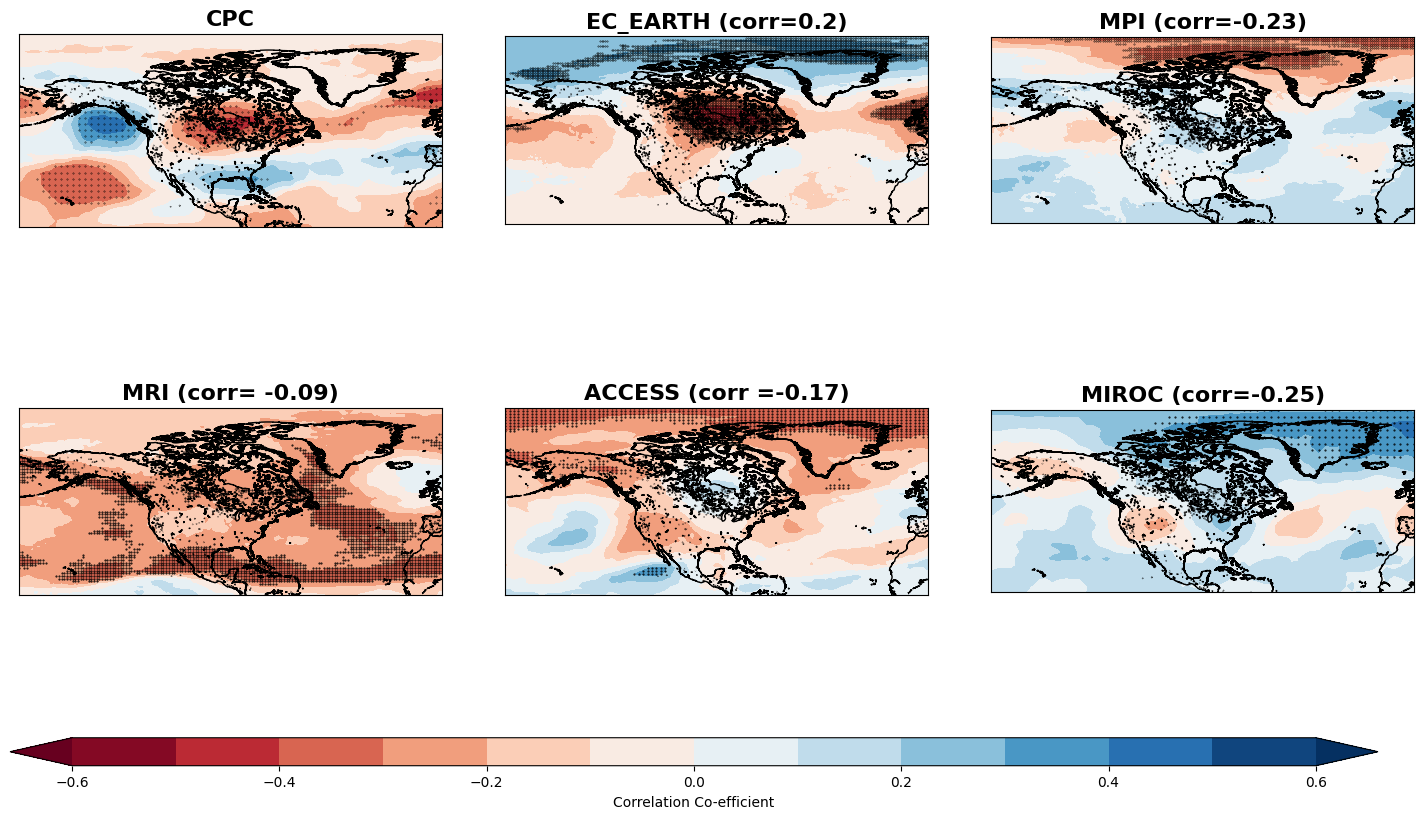

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# ---------- CPC ----------
m = Basemap(
    projection='cyl',
    llcrnrlon=min(result_cpc['lon_zg']),
    llcrnrlat=min(lat_cpc),
    urcrnrlon=max(result_cpc['lon_zg']),
    urcrnrlat=max(lat_cpc),
    resolution='h',
    ax=axes[0]
)
lon, lat = np.meshgrid(result_cpc['lon_zg'], lat_cpc)
x, y = m(lon, lat)
cs = m.contourf(x, y, cor_cpc_slice, np.arange(-0.6, 0.7, 0.1),
                cmap='RdBu', extend='both')
m.plot(result_cpc['lon_list1'], result_cpc['lat_list1'], 'bo',
       markersize=0.3, color='k')
m.drawcoastlines()
axes[0].set_title('CPC',fontsize=16, fontweight='bold')

# ---------- EC ----------
m = Basemap(
    projection='cyl',
    llcrnrlon=min(result_ec['lon_zg']),
    llcrnrlat=min(lat_ec),
    urcrnrlon=max(result_ec['lon_zg']),
    urcrnrlat=max(lat_ec),
    resolution='h',
    ax=axes[1]
)
lon, lat = np.meshgrid(result_ec['lon_zg'], lat_ec)
x, y = m(lon, lat)
cs = m.contourf(x, y, cor_ec_slice, np.arange(-0.6, 0.7, 0.1),
                cmap='RdBu', extend='both')
m.plot(result_ec['lon_list1'], result_ec['lat_list1'], 'bo',
       markersize=0.3, color='k')
m.drawcoastlines()
axes[1].set_title('EC_EARTH (corr=0.2)',fontsize=16, fontweight='bold')

# ---------- MPI ----------
m = Basemap(
    projection='cyl',
    llcrnrlon=min(result_mpi['lon_zg']),
    llcrnrlat=min(lat_mpi),
    urcrnrlon=max(result_mpi['lon_zg']),
    urcrnrlat=max(lat_mpi),
    resolution='h',
    ax=axes[2]
)
lon, lat = np.meshgrid(result_mpi['lon_zg'], lat_mpi)
x, y = m(lon, lat)
cs = m.contourf(x, y, cor_mpi_slice, np.arange(-0.6, 0.7, 0.1),
                cmap='RdBu', extend='both')
m.plot(result_mpi['lon_list1'], result_mpi['lat_list1'], 'bo',
       markersize=0.3, color='k')
m.drawcoastlines()
axes[2].set_title('MPI (corr=-0.23)',fontsize=16, fontweight='bold')

# ---------- MRI ----------
m = Basemap(
    projection='cyl',
    llcrnrlon=min(result_mri['lon_zg']),
    llcrnrlat=min(lat_mri),
    urcrnrlon=max(result_mri['lon_zg']),
    urcrnrlat=max(lat_mri),
    resolution='h',
    ax=axes[3]
)
lon, lat = np.meshgrid(result_mri['lon_zg'], lat_mri)
x, y = m(lon, lat)
cs = m.contourf(x, y, cor_mri_slice, np.arange(-0.6, 0.7, 0.1),
                cmap='RdBu', extend='both')
m.plot(result_mri['lon_list1'], result_mri['lat_list1'], 'bo',
       markersize=0.5, color='k')
m.drawcoastlines()
axes[3].set_title('MRI (corr= -0.09)',fontsize=16, fontweight='bold')

# ---------- ACCESS ----------
m = Basemap(
    projection='cyl',
    llcrnrlon=min(result_ac['lon_zg']),
    llcrnrlat=min(lat_ac),
    urcrnrlon=max(result_ac['lon_zg']),
    urcrnrlat=max(lat_ac),
    resolution='h',
    ax=axes[4]
)
lon, lat = np.meshgrid(result_ac['lon_zg'], lat_ac)
x, y = m(lon, lat)
cs = m.contourf(x, y, cor_ac_slice, np.arange(-0.6, 0.7, 0.1),
                cmap='RdBu', extend='both')
m.plot(result_ac['lon_list1'], result_ac['lat_list1'], 'bo',
       markersize=0.5, color='k')
m.drawcoastlines()
axes[4].set_title('ACCESS (corr =-0.17)',fontsize=16, fontweight='bold')

# ---------- MIROC ----------
m = Basemap(
    projection='cyl',
    llcrnrlon=min(result_miroc['lon_zg']),
    llcrnrlat=min(lat_miroc),
    urcrnrlon=max(result_miroc['lon_zg']),
    urcrnrlat=max(lat_miroc),
    resolution='h',
    ax=axes[5]
)
lon, lat = np.meshgrid(result_miroc['lon_zg'], lat_miroc)
x, y = m(lon, lat)
cs = m.contourf(x, y, cor_miroc_slice, np.arange(-0.6, 0.7, 0.1),
                cmap='RdBu', extend='both')
m.plot(result_miroc['lon_list1'], result_miroc['lat_list1'], 'bo',
       markersize=0.5, color='k')
m.drawcoastlines()
axes[5].set_title('MIROC (corr=-0.25)',fontsize=16, fontweight='bold')




fig.set_constrained_layout(False) 
fig.subplots_adjust(hspace=0.005, wspace=0.15, bottom=0.14)  

# shared colorbar below all panels
cbar_ax = fig.add_axes([0.12, 0.06, 0.76, 0.028]) 
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Correlation Co-efficient')

os.chdir("C:/Users/tamee/Downloads")
plt.savefig('Panel_plot.png',dpi=300, bbox_inches='tight')


In [220]:
from scipy.interpolate import RegularGridInterpolator

In [221]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator

def compute_correlation(lat_zg, lon_zg, cor_model,
                        lat_cpc, lon_cpc, cor_cpc_slice):
    """
    Interpolates model correlation field  to CPC grid 
    and computes correlation coefficient with CPC.

    Parameters
    ----------
    lat_zg : 1D array
        Model latitudes
    lon_zg : 1D array
        Model longitudes
    cor_ec : 2D array (lat_zg x lon_zg)
        Model correlation field
    lat_cpc : 1D array
        CPC latitudes
    lon_cpc : 1D array
        CPC longitudes
    cor_cpc_slice : 2D array (lat_cpc x lon_cpc)
        CPC correlation field to compare against

    Returns
    -------
    r : float
        Pearson correlation coefficient
    """

    # Interpolator on model grid
    fA = RegularGridInterpolator((lat_zg, lon_zg), cor_model,
                                 bounds_error=False, fill_value=np.nan)

    # Build target grid (CPC grid)
    LATB, LONB = np.meshgrid(lat_cpc, lon_cpc, indexing='ij')
    pts = np.column_stack((LATB.ravel(), LONB.ravel()))

    # Interpolate model field onto CPC grid
    cpc_on_model = fA(pts).reshape(LATB.shape)

    # Apply mask (only finite values in both datasets)
    mask = np.isfinite(cpc_on_model) & np.isfinite(cor_cpc_slice)

    if np.sum(mask) == 0:
        return np.nan  # no overlap

    # Correlation
    r = np.corrcoef(cpc_on_model[mask].ravel(),
                    cor_cpc_slice[mask].ravel())[0, 1]
    return r


In [222]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator

def compute_correlation(lat_zg, lon_zg, cor_model,
                        lat_cpc, lon_cpc, cor_cpc_slice):
    """
    Interpolate cor_model(lat_zg, lon_zg) onto CPC grid (lat_cpc, lon_cpc)
    and return Pearson correlation with cor_cpc_slice.
    """

    # ---- coerce to plain numpy arrays ----
    lat_zg = np.asarray(getattr(lat_zg, "values", lat_zg)).astype(float)
    lon_zg = np.asarray(getattr(lon_zg, "values", lon_zg)).astype(float)
    cor_model = np.asarray(getattr(cor_model, "values", cor_model)).astype(float)

    lat_cpc = np.asarray(getattr(lat_cpc, "values", lat_cpc)).astype(float)
    lon_cpc = np.asarray(getattr(lon_cpc, "values", lon_cpc)).astype(float)
    cor_cpc_slice = np.asarray(getattr(cor_cpc_slice, "values", cor_cpc_slice)).astype(float)

    # Make sure data are contiguous (avoids .flags error path)
    cor_model = np.ascontiguousarray(cor_model)

    # ---- ensure axes are strictly ascending for RGI ----
    if lat_zg.ndim != 1 or lon_zg.ndim != 1:
        raise ValueError("lat_zg and lon_zg must be 1D.")
    if cor_model.shape != (lat_zg.size, lon_zg.size):
        raise ValueError("cor_model shape must be (len(lat_zg), len(lon_zg)).")

    if lat_zg[0] > lat_zg[-1]:
        lat_zg = lat_zg[::-1]
        cor_model = cor_model[::-1, :]
    if lon_zg[0] > lon_zg[-1]:
        lon_zg = lon_zg[::-1]
        cor_model = cor_model[:, ::-1]

    # ---- build interpolator on model grid ----
    fA = RegularGridInterpolator(
        (lat_zg, lon_zg),
        cor_model,
        bounds_error=False,
        fill_value=np.nan,
    )

    # ---- target CPC grid and interpolation ----
    LATB, LONB = np.meshgrid(lat_cpc, lon_cpc, indexing='ij')  # (nlat, nlon)
    pts = np.column_stack((LATB.ravel(), LONB.ravel()))
    model_on_cpc = fA(pts).reshape(LATB.shape)

    # ---- correlation on common finite mask ----
    mask = np.isfinite(model_on_cpc) & np.isfinite(cor_cpc_slice)
    if mask.sum() == 0:
        return np.nan

    r = np.corrcoef(model_on_cpc[mask].ravel(),
                    cor_cpc_slice[mask].ravel())[0, 1]
    return float(r)


In [223]:
r_ec = compute_correlation(lat_ec, result_ec['lon_zg'], cor_ec_slice,
                           lat_cpc, result_cpc['lon_zg'], cor_cpc_slice)

In [224]:
r_mpi = compute_correlation(lat_mpi, result_mpi['lon_zg'], cor_mpi_slice,
                            lat_cpc, result_cpc['lon_zg'], cor_cpc_slice)

In [225]:
r_mri = compute_correlation(lat_mri, result_mri['lon_zg'], cor_mri_slice,
                            lat_cpc, result_cpc['lon_zg'], cor_cpc_slice)

In [226]:
r_ac = compute_correlation(lat_ac, result_ac['lon_zg'], cor_ac_slice,
                            lat_cpc, result_cpc['lon_zg'], cor_cpc_slice)

In [227]:
r_miroc = compute_correlation(lat_miroc, result_miroc['lon_zg'], cor_miroc_slice,
                            lat_cpc, result_cpc['lon_zg'], cor_cpc_slice)

In [243]:

year = np.arange(1,37)

In [286]:
r_ac

-0.17220209055026947

In [230]:
cpc_denoise= result_cpc['denoised_z500']
ec_denoise=  result_ec['denoised_z500']
mpi_denoise= result_mpi['denoised_z500']
mri_denoise= result_mri['denoised_z500']
ac_denoise= result_ac['denoised_z500']
miroc_denoise= result_miroc['denoised_z500']

In [231]:
import statsmodels.api as sm


In [251]:
slope_cpc_avg, intercept_cpc_avg = np.polyfit(year, cpc_avg, 1)
trend_cpc_avg = slope_cpc_avg * year + intercept_cpc_avg

slope_cpc_denoise, intercept_cpc_denoise = np.polyfit(year, cpc_denoise, 1)
trend_cpc_denoise = slope_cpc_denoise * year + intercept_cpc_denoise


In [258]:
slope_ec_avg, intercept_ec_avg = np.polyfit(year, ec_earth_avg, 1)
trend_ec_avg = slope_ec_avg * year + intercept_ec_avg

slope_ec_denoise, intercept_ec_denoise = np.polyfit(year, ec_denoise, 1)
trend_ec_denoise = slope_ec_denoise * year + intercept_ec_denoise


In [261]:
slope_mpi_avg, intercept_mpi_avg = np.polyfit(year, mpi_avg, 1)
trend_mpi_avg = slope_mpi_avg * year + intercept_mpi_avg

slope_mpi_denoise, intercept_mpi_denoise = np.polyfit(year, mpi_denoise, 1)
trend_mpi_denoise = slope_mpi_denoise * year + intercept_mpi_denoise


In [264]:
# Linear trends for MRI series
slope_mri_avg, intercept_mri_avg = np.polyfit(year, mri_avg, 1)
trend_mri_avg = slope_mri_avg * year + intercept_mri_avg

slope_mri_denoise, intercept_mri_denoise = np.polyfit(year, mri_denoise, 1)
trend_mri_denoise = slope_mri_denoise * year + intercept_mri_denoise


In [267]:
# Linear trends for ACCESS series
slope_access_avg, intercept_access_avg = np.polyfit(year, access_avg, 1)
trend_access_avg = slope_access_avg * year + intercept_access_avg

slope_access_denoise, intercept_access_denoise = np.polyfit(year, ac_denoise, 1)
trend_access_denoise = slope_access_denoise * year + intercept_access_denoise


In [270]:
# Linear trends for MIROC series
slope_miroc_avg, intercept_miroc_avg = np.polyfit(year, miroc_avg, 1)
trend_miroc_avg = slope_miroc_avg * year + intercept_miroc_avg

slope_miroc_denoise, intercept_miroc_denoise = np.polyfit(year, miroc_denoise, 1)
trend_miroc_denoise = slope_miroc_denoise * year + intercept_miroc_denoise


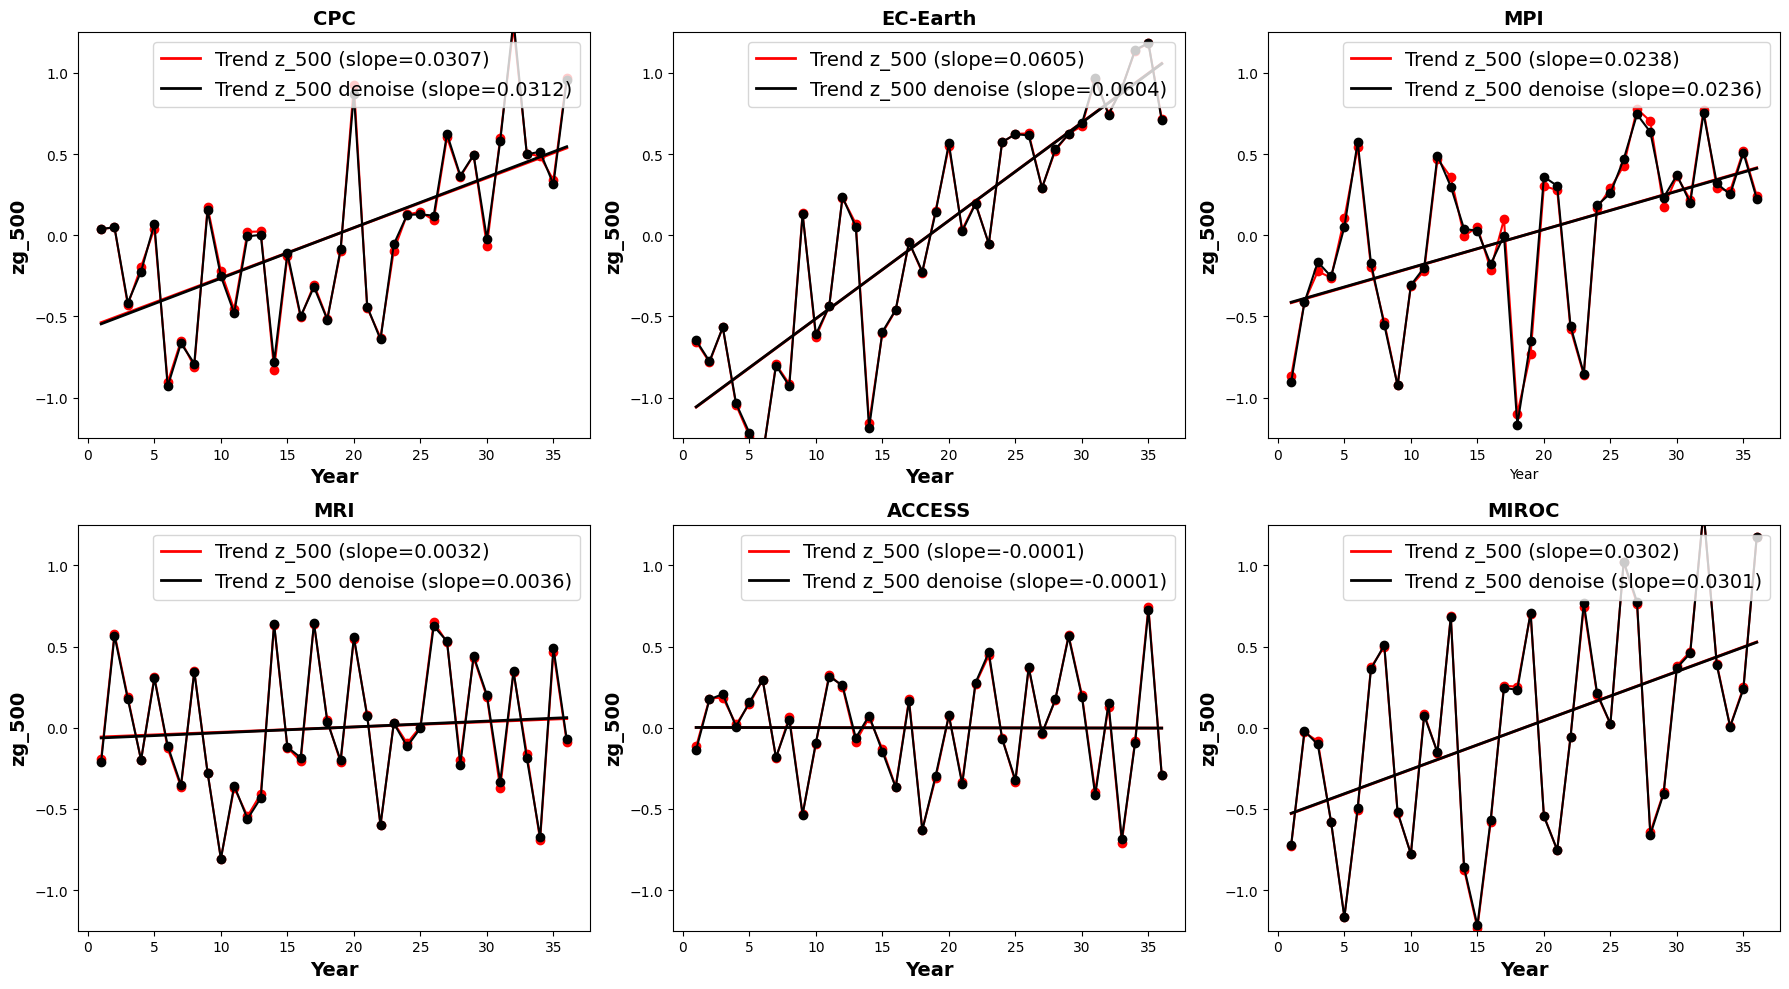

In [282]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# -------- CPC --------
axes[0].plot(year, cpc_avg, marker='o', color="red")
axes[0].plot(year, trend_cpc_avg, 'r-', lw=2,
             label=f'Trend z_500 (slope={slope_cpc_avg:.4f})')

axes[0].plot(year, cpc_denoise, marker='o', color="black")
axes[0].plot(year, trend_cpc_denoise, color='black', lw=2,
             label=f'Trend z_500 denoise (slope={slope_cpc_denoise:.4f})')

axes[0].set_title("CPC", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Year",fontsize=14, fontweight="bold")
axes[0].set_ylabel("zg_500",fontsize=14, fontweight="bold")
axes[0].legend(loc="upper right",fontsize=14)
axes[0].set_ylim(-1.25, 1.25)
# -------- EC-Earth --------
axes[1].plot(year, ec_earth_avg, marker='o', color="red")
axes[1].plot(year, trend_ec_avg, 'r-', lw=2,
             label=f'Trend z_500 (slope={slope_ec_avg:.4f})')

axes[1].plot(year, ec_denoise, marker='o', color="black")
axes[1].plot(year, trend_ec_denoise, color='black', lw=2,
             label=f'Trend z_500 denoise (slope={slope_ec_denoise:.4f})')

axes[1].set_title("EC-Earth", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Year",fontsize=14, fontweight="bold")
axes[1].set_ylabel("zg_500",fontsize=14, fontweight="bold")
axes[1].legend(loc="upper right",fontsize=14)
axes[1].set_ylim(-1.25, 1.25)
# -------- MPI --------
axes[2].plot(year, mpi_avg, marker='o', color="red")
axes[2].plot(year, trend_mpi_avg, 'r-', lw=2,
             label=f'Trend z_500 (slope={slope_mpi_avg:.4f})')

axes[2].plot(year, mpi_denoise, marker='o', color="black")
axes[2].plot(year, trend_mpi_denoise, color='black', lw=2,
             label=f'Trend z_500 denoise (slope={slope_mpi_denoise:.4f})')

axes[2].set_title("MPI", fontsize=14, fontweight="bold")
axes[2].set_xlabel("Year")
axes[2].set_ylabel("zg_500",fontsize=14, fontweight="bold")
axes[2].legend(loc="upper right",fontsize=14)
axes[2].set_ylim(-1.25, 1.25)
# -------- MRI --------
axes[3].plot(year, mri_avg, marker='o', color="red")
axes[3].plot(year, trend_mri_avg, 'r-', lw=2,
             label=f'Trend z_500 (slope={slope_mri_avg:.4f})')

axes[3].plot(year, mri_denoise, marker='o', color="black")
axes[3].plot(year, trend_mri_denoise, color='black', lw=2,
             label=f'Trend z_500 denoise (slope={slope_mri_denoise:.4f})')

axes[3].set_title("MRI", fontsize=14, fontweight="bold")
axes[3].set_xlabel("Year",fontsize=14, fontweight="bold")
axes[3].set_ylabel("zg_500",fontsize=14, fontweight="bold")
axes[3].legend(loc="upper right",fontsize=14)
axes[3].set_ylim(-1.25, 1.25)
# -------- ACCESS --------
axes[4].plot(year, access_avg, marker='o', color="red")
axes[4].plot(year, trend_access_avg, 'r-', lw=2,
             label=f'Trend z_500 (slope={slope_access_avg:.4f})')

axes[4].plot(year, ac_denoise, marker='o', color="black")
axes[4].plot(year, trend_access_denoise, color='black', lw=2,
             label=f'Trend z_500 denoise (slope={slope_access_denoise:.4f})')

axes[4].set_title("ACCESS", fontsize=14, fontweight="bold")
axes[4].set_xlabel("Year",fontsize=14, fontweight="bold")
axes[4].set_ylabel("zg_500",fontsize=14, fontweight="bold")
axes[4].legend(loc="upper right",fontsize=14)
axes[4].set_ylim(-1.25, 1.25)
# -------- MIROC --------
axes[5].plot(year, miroc_avg, marker='o', color="red")
axes[5].plot(year, trend_miroc_avg, 'r-', lw=2,
             label=f'Trend z_500 (slope={slope_miroc_avg:.4f})')

axes[5].plot(year, miroc_denoise, marker='o', color="black")
axes[5].plot(year, trend_miroc_denoise, color='black', lw=2,
             label=f'Trend z_500 denoise (slope={slope_miroc_denoise:.4f})')

axes[5].set_title("MIROC", fontsize=14, fontweight="bold")
axes[5].set_xlabel("Year",fontsize=14, fontweight="bold")
axes[5].set_ylabel("zg_500",fontsize=14, fontweight="bold")
axes[5].legend(loc="upper right",fontsize=14)
axes[5].set_ylim(-1.25, 1.25)
# ----- Layout adjustments -----
plt.tight_layout()
os.chdir("C:/Users/tamee/Downloads")
plt.savefig('Timeseries_panel.png',dpi=300, bbox_inches='tight')

